In [1]:
if __name__=="__main__":
	import sys
	sys.path.append('/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/Scripts')
	
from src.SMT_Analysis_BP.databases.trajectory_analysis_script import *
from scipy.interpolate import griddata
from scipy.stats import norm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.colors
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from scipy.stats import gaussian_kde
import pandas as pd
import os
import datetime
import numpy as np
from src.SMT_Analysis_BP.helpers.MSD_Utils import *
from src.SMT_Analysis_BP.helpers.plotting_functions import *
from src.SMT_Analysis_BP.helpers.import_functions import *
from src.SMT_Analysis_BP.helpers.Analysis_functions import *
from src.SMT_Analysis_BP.helpers.diff_mw import *
import mpl_toolkits.mplot3d.art3d as art3d
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
from src.SMT_Analysis_BP.Random.scalebars import *
from src.SMT_Analysis_BP.Random.Convert_csv_mat import *
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from scipy import stats, ndimage,io
import json
import matplotlib.gridspec as gs
import csv  
from sklearn.cluster import OPTICS
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')  
from sklearn.cluster import DBSCAN
from cgitb import small
import src.SMT_Analysis_BP.helpers.smallestenclosingcircle as smallestenclosingcircle
import math
import src.SMT_Analysis_BP.Random.guassian_fit as gaussian_fit
import src.SMT_Analysis_BP.helpers.fbm_utility as fbm_utility
import src.SMT_Analysis_BP.helpers.simulate_foci as simulate_foci
import src.SMT_Analysis_BP.helpers.simulate_cells as simulate_cells
import src.SMT_Analysis_BP.helpers.SMT_converters as smt
import matplotlib.patches as mpatches
import pickle
import src.SMT_Analysis_BP.Parameter_Store.global_params as param_store

/var/folders/_t/qlzp5l894v16vmr8m_81x5x80000gn/T/ipykernel_9399/3446417043.py:41: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')


In [2]:
globals = param_store.PIXELSIZES
from warnings import filterwarnings
filterwarnings('ignore',module="DeprecationWarning")
#ignore deprecated warnings
#ignore stacklevel=2 warnings

In [3]:
def perform_run_analysis_bulk(path_keyword_dict:dict,**kwargs)->list:
    '''
    We will do the run analysis in bulk for a set of data which are repeats of a condition

    Parameters:
    -----------
    path_keyword_dict:dict
        A dictionary of the form {cd:{t_string:_,unique_name:_}}
        CD: is the condition directory
        t_string: is the string which if of internal use and signifies the file naming convention
        unique_name: is the unique name of the condition
    **kwargs:
        Keyword arguments which are passed to the run_analysis function
        TODO update this to be more specific

    Returns:
    --------
    list
        A list of the results of the run_analysis function for each condition.
        Each index is a realization of the trajectory_analysis_script.run_analysis class
    '''
    results = {key:{} for key in path_keyword_dict.keys()}
    for data_type,data in path_keyword_dict.items():
        for cd,names in data.items():
            obj= run_analysis(cd,names.get("t_string"),unique_name=names.get("name"))
            obj.read_parameters(minimum_percent_per_drop_in = 0.5, 
                                t_len_u = 100, 
                                t_len_l = 1, 
                                minimum_tracks_per_drop = 3,
                                cluster_t_len_l=7)
            
            obj.get_blob_parameters(threshold=1e-4,
                                    overlap=0,
                                    detection_name='bp',
                                    min_sigma=1/np.sqrt(2),
                                    max_sigma=2.5/np.sqrt(2),
                                    num_sigma=100,
                                    median = False)

            obj.get_fitting_parameters(kwargs={"mask_size":3,
                                                "plot_fit":False,
                                                "fitting_image":"LAP",
                                                "radius_func":np.mean,#identity,
                                                "residual_func":residuals_gaus2d,
                                                "sigma_range":0.5,
                                                "centroid_range":0.5,
                                                "height_range":2})
            obj.type_of_blob ="Scale"
            obj.a_file_style = "new"
            obj.overwrite_cell_localizations = True
            obj.run_flow(masked_movies=True)
            if kwargs.get("save",True):
                obj._make_SMAUG_files(dir_name = "SMAUG_AUTO")
                obj._store_combined_SMAUG_files(combined_dir_name="/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/Combined_SMT_THESIS_CHAPTER_5/Combined_SMAUG/AUTO_STYLE/{}".format(data_type))
            results[data_type][names.get("name")] = obj
    #pickle the results
    with open("/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/Combined_SMT_THESIS_CHAPTER_5/{}_results.pkl".format(data_type),"wb") as f:
        pickle.dump(results,f)
                

In [4]:
rpoc_ez_paths_keywords = {"RPOC_EZ":{
    "/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/Other_RPOC":{"t_string":"rpoc","name":"20180813_Other_RPOC"},
    "/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/RPOC_new":{"t_string":"RPOC","name":"20181003_RPOC_new"},
    "/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/new_days/2019057/rpoc_ez":{"t_string":"rpoc_ez","name":"newdays_20190527_rpoc_ez"} 
    }
}
rpoc_m9_paths_keywords = {"RPOC_M9":{
    "/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/12/rpoc_m9":{"t_string":"rpoc_m9","name":"12_rpoc_m9"}, 
    "/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/12/rpoc_m9_2":{"t_string":"rpoc_m9","name":"12_rpoc_m9_2"},
    "/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/rpoc_M9/20190515":{"t_string":"rpoc_M9","name":"20190515_rpoc_m9"}
    }
}
rpoc_hex5_paths_keywords = {"RPOC_Hex5":{
    "/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/15/rp_ez_hex5":{"t_string":"rp_ez_hex5","name":"15_rp_hex5"}, 
    "/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/15/rp_ez_hex5_2":{"t_string":"rp_ez_hex5","name":"15_rp_hex5_2"},
    "/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/16/rp_ez_hex5":{"t_string":"rp_ez_hex5","name":"16_rp_hex5"} 
    }
}
laci_laco_ez_paths_keywords = {"LL_EZ":{
    "/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/new_days/20190527/ll_ez":{"t_string":"laco_laci_ez","name":"newdays_20190527_ll_ez"}, 
    "/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/17/ll_ez":{"t_string":"ll_ez","name":"17_ll_ez"},
    "/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/17/ll_ez_2":{"t_string":"ll_ez","name":"17_ll_ez_2"}
    }
}
laci_laco_m9_paths_keywords = {"LL_M9":{
    "/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/16/ll_m9":{"t_string":"ll_m9","name":"16_ll_m9"},
    "/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/16/ll_m9_2":{"t_string":"ll_m9","name":"16_ll_m9_2"},
    "/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/16/ll_m9_3":{"t_string":"ll_m9","name":"16_ll_m9_3"}
    }
}
laci_laco_hex5_paths_keywords = {"LL_Hex5":{
    "/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/16/ll_hex5":{"t_string":"ll_ez_hex5","name":"16_ll_hex5"},
    "/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/16/ll_hex5_2":{"t_string":"ll_ez_hex5","name":"16_ll_hex5_2"},
    "/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/16/ll_hex5_3":{"t_string":"ll_ez_hex5","name":"16_ll_hex5_3"}
}
}
    

In [ ]:
#do the analysis
# perform_run_analysis_bulk(rpoc_ez_paths_keywords,save=True)
# perform_run_analysis_bulk(rpoc_m9_paths_keywords,save=True)
# perform_run_analysis_bulk(rpoc_hex5_paths_keywords,save=True)

# perform_run_analysis_bulk(laci_laco_ez_paths_keywords,save=True)
# perform_run_analysis_bulk(laci_laco_m9_paths_keywords,save=True)
# perform_run_analysis_bulk(laci_laco_hex5_paths_keywords,save=True)

In [5]:
#load the pickle files
rp_ez_pickle = "/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/Combined_SMT_THESIS_CHAPTER_5/RPOC_EZ_results.pkl"
rp_m9_pickle = "/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/Combined_SMT_THESIS_CHAPTER_5/RPOC_M9_results.pkl"
rp_hex5_pickle = "/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/Combined_SMT_THESIS_CHAPTER_5/RPOC_Hex5_results.pkl"

ll_ez_pickle = "/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/Combined_SMT_THESIS_CHAPTER_5/LL_EZ_results.pkl"
ll_m9_pickle = "/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/Combined_SMT_THESIS_CHAPTER_5/LL_M9_results.pkl"
ll_hex5_pickle = "/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/Combined_SMT_THESIS_CHAPTER_5/LL_Hex5_results.pkl"

In [6]:
#load them
with open(rp_ez_pickle,"rb") as f:
    rp_ez_results = pickle.load(f)
with open(rp_m9_pickle,"rb") as f:
    rp_m9_results = pickle.load(f)
with open(rp_hex5_pickle,"rb") as f:
    rp_hex5_results = pickle.load(f)
with open(ll_ez_pickle,"rb") as f:
    ll_ez_results = pickle.load(f)
with open(ll_m9_pickle,"rb") as f:
    ll_m9_results = pickle.load(f)
with open(ll_hex5_pickle,"rb") as f:
    ll_hex5_results = pickle.load(f)



In [42]:
MIN_TRACK_LENGTH = 7
MAX_TRACK_LENGTH = 7

In [43]:
from src.SMT_Analysis_BP.helpers.MSD_Utils import MSD_Calculations

RPOC_ez_MSD = MSD_Calculations(list(list(rp_ez_results.values())[0].values()),min_track_length=MIN_TRACK_LENGTH,max_track_length=MAX_TRACK_LENGTH)
RPOC_m9_MSD = MSD_Calculations(list(list(rp_m9_results.values())[0].values()),min_track_length=MIN_TRACK_LENGTH,max_track_length=MAX_TRACK_LENGTH)
RPOC_hex5_MSD = MSD_Calculations(list(list(rp_hex5_results.values())[0].values()),min_track_length=MIN_TRACK_LENGTH,max_track_length=MAX_TRACK_LENGTH)

LL_ez_MSD = MSD_Calculations(list(list(ll_ez_results.values())[0].values()),min_track_length=MIN_TRACK_LENGTH,max_track_length=MAX_TRACK_LENGTH)
LL_m9_MSD = MSD_Calculations(list(list(ll_m9_results.values())[0].values()),min_track_length=MIN_TRACK_LENGTH,max_track_length=MAX_TRACK_LENGTH)
LL_hex5_MSD = MSD_Calculations(list(list(ll_hex5_results.values())[0].values()),min_track_length=MIN_TRACK_LENGTH,max_track_length=MAX_TRACK_LENGTH)

#save to pickle in the Combined MSD folder
MSD_folder_combined = "/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/Combined_SMT_THESIS_CHAPTER_5/Combined_MSD"
if not os.path.exists(MSD_folder_combined):
    os.makedirs(MSD_folder_combined)
with open(os.path.join(MSD_folder_combined,"RPOC_ez_MSD_min_{0}_max_{1}.pkl".format(MIN_TRACK_LENGTH,MAX_TRACK_LENGTH)),"wb") as f:
    pickle.dump(RPOC_ez_MSD,f)
with open(os.path.join(MSD_folder_combined,"RPOC_m9_MSD_min_{0}_max_{1}.pkl".format(MIN_TRACK_LENGTH,MAX_TRACK_LENGTH)),"wb") as f:
    pickle.dump(RPOC_m9_MSD,f)
with open(os.path.join(MSD_folder_combined,"RPOC_hex5_MSD_min_{0}_max_{1}.pkl".format(MIN_TRACK_LENGTH,MAX_TRACK_LENGTH)),"wb") as f:
    pickle.dump(RPOC_hex5_MSD,f)
with open(os.path.join(MSD_folder_combined,"LL_ez_MSD_min_{0}_max_{1}.pkl".format(MIN_TRACK_LENGTH,MAX_TRACK_LENGTH)),"wb") as f:
    pickle.dump(LL_ez_MSD,f)
with open(os.path.join(MSD_folder_combined,"LL_m9_MSD_min_{0}_max_{1}.pkl".format(MIN_TRACK_LENGTH,MAX_TRACK_LENGTH)),"wb") as f:
    pickle.dump(LL_m9_MSD,f)
with open(os.path.join(MSD_folder_combined,"LL_hex5_MSD_min_{0}_max_{1}.pkl".format(MIN_TRACK_LENGTH,MAX_TRACK_LENGTH)),"wb") as f:
    pickle.dump(LL_hex5_MSD,f)

# #save a json with the parameter used in the MSD calculations
# with open(os.path.join(MSD_folder_combined,"MSD_parameters.json"),"w") as f:
#     json.dump({"min_track_length":MIN_TRACK_LENGTH,"max_track_length":MAX_TRACK_LENGTH},f)


    



        ##############################################################################################################
        #You have initialized a Calculation class with the following parameters:
        #pixel_size: 0.13
        #frame_length: 0.02
        #pixel_unit: um
        #frame_unit: s
        

        ##############################################################################################################
        #You have initialized a Calculation class with the following parameters:
        #pixel_size: 0.13
        #frame_length: 0.02
        #pixel_unit: um
        #frame_unit: s
        

        ##############################################################################################################
        #You have initialized a Calculation class with the following parameters:
        #pixel_size: 0.13
        #frame_length: 0.02
        #pixel_unit: um
        #frame_unit: s
        

        ##########################################################

In [44]:
#load the MSD files
RPOC_ez_MSD = pickle.load(open("/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/Combined_SMT_THESIS_CHAPTER_5/Combined_MSD/RPOC_ez_MSD_min_{0}_max_{1}.pkl".format(MIN_TRACK_LENGTH,MAX_TRACK_LENGTH),"rb"))
RPOC_m9_MSD = pickle.load(open("/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/Combined_SMT_THESIS_CHAPTER_5/Combined_MSD/RPOC_m9_MSD_min_{0}_max_{1}.pkl".format(MIN_TRACK_LENGTH,MAX_TRACK_LENGTH),"rb"))
RPOC_hex5_MSD = pickle.load(open("/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/Combined_SMT_THESIS_CHAPTER_5/Combined_MSD/RPOC_hex5_MSD_min_{0}_max_{1}.pkl".format(MIN_TRACK_LENGTH,MAX_TRACK_LENGTH),"rb"))

LL_ez_MSD = pickle.load(open("/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/Combined_SMT_THESIS_CHAPTER_5/Combined_MSD/LL_ez_MSD_min_{0}_max_{1}.pkl".format(MIN_TRACK_LENGTH,MAX_TRACK_LENGTH),"rb"))
LL_m9_MSD = pickle.load(open("/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/Combined_SMT_THESIS_CHAPTER_5/Combined_MSD/LL_m9_MSD_min_{0}_max_{1}.pkl".format(MIN_TRACK_LENGTH,MAX_TRACK_LENGTH),"rb"))
LL_hex5_MSD = pickle.load(open("/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/Combined_SMT_THESIS_CHAPTER_5/Combined_MSD/LL_hex5_MSD_min_{0}_max_{1}.pkl".format(MIN_TRACK_LENGTH,MAX_TRACK_LENGTH),"rb"))


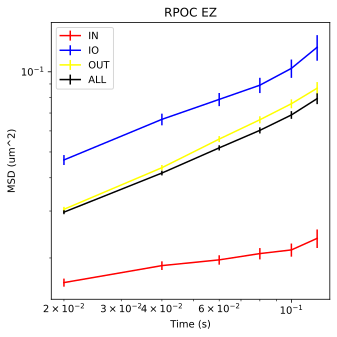

In [53]:
msd_rpoc_ez_curve_in = RPOC_ez_MSD.combined_store["IN"].ensemble_MSD
msd_error_rpoc_ez_curve_in = RPOC_ez_MSD.combined_store["IN"].ensemble_MSD_error
msd_rpoc_ez_curve_io = RPOC_ez_MSD.combined_store["IO"].ensemble_MSD
msd_error_rpoc_ez_curve_io = RPOC_ez_MSD.combined_store["IO"].ensemble_MSD_error
msd_rpoc_ez_curve_out = RPOC_ez_MSD.combined_store["OUT"].ensemble_MSD
msd_error_rpoc_ez_curve_out = RPOC_ez_MSD.combined_store["OUT"].ensemble_MSD_error
msd_rpoc_ez_curve_all = RPOC_ez_MSD.combined_store["ALL"].ensemble_MSD
msd_error_rpoc_ez_curve_all = RPOC_ez_MSD.combined_store["ALL"].ensemble_MSD_error

#repeat for the LL
msd_ll_ez_curve_in = LL_ez_MSD.combined_store["IN"].ensemble_MSD
msd_error_ll_ez_curve_in = LL_ez_MSD.combined_store["IN"].ensemble_MSD_error
msd_ll_ez_curve_io = LL_ez_MSD.combined_store["IO"].ensemble_MSD
msd_error_ll_ez_curve_io = LL_ez_MSD.combined_store["IO"].ensemble_MSD_error
msd_ll_ez_curve_out = LL_ez_MSD.combined_store["OUT"].ensemble_MSD
msd_error_ll_ez_curve_out = LL_ez_MSD.combined_store["OUT"].ensemble_MSD_error
msd_ll_ez_curve_all = LL_ez_MSD.combined_store["ALL"].ensemble_MSD
msd_error_ll_ez_curve_all = LL_ez_MSD.combined_store["ALL"].ensemble_MSD_error

import matplotlib.gridspec as gs
fig =plt.figure(figsize=(5,5))
gspec = gs.GridSpec(1,1)
ax = fig.add_subplot(gspec[0,0])
ax.errorbar(list(msd_rpoc_ez_curve_in.keys()),list(msd_rpoc_ez_curve_in.values()),yerr=np.array(list(msd_error_rpoc_ez_curve_in.values()))*1.96,label="IN",color="red")
ax.errorbar(list(msd_rpoc_ez_curve_io.keys()),list(msd_rpoc_ez_curve_io.values()),yerr=np.array(list(msd_error_rpoc_ez_curve_io.values()))*1.96,label="IO",color="blue")
ax.errorbar(list(msd_rpoc_ez_curve_out.keys()),list(msd_rpoc_ez_curve_out.values()),yerr=np.array(list(msd_error_rpoc_ez_curve_out.values()))*1.96,label="OUT",color="yellow")
ax.errorbar(list(msd_rpoc_ez_curve_all.keys()),list(msd_rpoc_ez_curve_all.values()),yerr=np.array(list(msd_error_rpoc_ez_curve_all.values()))*1.96,label="ALL",color="black")
ax.set_xlabel("Time (s)")
ax.set_ylabel("MSD (um^2)")
ax.set_title("RPOC EZ")
ax.set_yscale("log")
ax.set_xscale("log")
ax.legend()
plt.show()



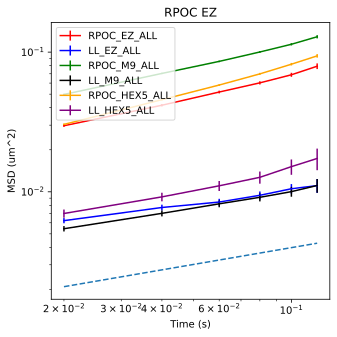

In [61]:
msd_rpoc_m9_curve_all = RPOC_m9_MSD.combined_store["ALL"].ensemble_MSD
msd_rpoc_hex5_curve_all = RPOC_hex5_MSD.combined_store["ALL"].ensemble_MSD

msd_ll_m9_curve_all = LL_m9_MSD.combined_store["ALL"].ensemble_MSD
msd_ll_hex5_curve_all = LL_hex5_MSD.combined_store["ALL"].ensemble_MSD

fig =plt.figure(figsize=(5,5))
gspec = gs.GridSpec(1,1)
ax = fig.add_subplot(gspec[0,0])

ax.errorbar(list(msd_rpoc_ez_curve_all.keys()),list(msd_rpoc_ez_curve_all.values()),yerr=np.array(list(msd_error_rpoc_ez_curve_all.values()))*1.96,label="RPOC_EZ_ALL",color="red")
ax.errorbar(list(msd_ll_ez_curve_all.keys()),list(msd_ll_ez_curve_all.values()),yerr=np.array(list(msd_error_ll_ez_curve_all.values()))*1.96,label="LL_EZ_ALL",color="blue")
ax.errorbar(list(msd_rpoc_m9_curve_all.keys()),list(msd_rpoc_m9_curve_all.values()),yerr=np.array(list(RPOC_m9_MSD.combined_store["ALL"].ensemble_MSD_error.values()))*1.96,label="RPOC_M9_ALL",color="green")
ax.errorbar(list(msd_ll_m9_curve_all.keys()),list(msd_ll_m9_curve_all.values()),yerr=np.array(list(LL_m9_MSD.combined_store["ALL"].ensemble_MSD_error.values()))*1.96,label="LL_M9_ALL",color="black")
ax.errorbar(list(msd_rpoc_hex5_curve_all.keys()),list(msd_rpoc_hex5_curve_all.values()),yerr=np.array(list(RPOC_hex5_MSD.combined_store["ALL"].ensemble_MSD_error.values()))*1.96,label="RPOC_HEX5_ALL",color="orange")
ax.errorbar(list(msd_ll_hex5_curve_all.keys()),list(msd_ll_hex5_curve_all.values()),yerr=np.array(list(LL_hex5_MSD.combined_store["ALL"].ensemble_MSD_error.values()))*1.96,label="LL_HEX5_ALL",color="purple")


ax.plot(list(msd_ll_ez_curve_in.keys()),0.01*np.array(list(msd_ll_ez_curve_in.keys()))**0.4,linestyle="--")

ax.set_xlabel("Time (s)")
ax.set_ylabel("MSD (um^2)")
ax.set_title("RPOC EZ")
ax.set_yscale("log")
ax.set_xscale("log")

# ax.set_xlim(0,0.24)
ax.legend()
plt.show()


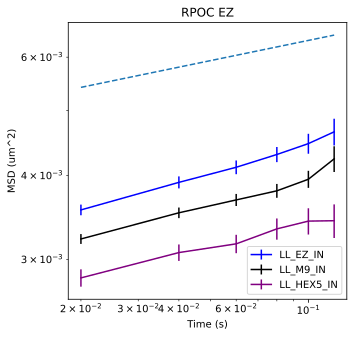

In [67]:
#repeat for IN
msd_rpoc_ez_curve_in = RPOC_ez_MSD.combined_store["IN"].ensemble_MSD
msd_error_rpoc_ez_curve_in = RPOC_ez_MSD.combined_store["IN"].ensemble_MSD_error
msd_rpoc_m9_curve_in = RPOC_m9_MSD.combined_store["IN"].ensemble_MSD
msd_error_rpoc_m9_curve_in = RPOC_m9_MSD.combined_store["IN"].ensemble_MSD_error
msd_rpoc_hex5_curve_in = RPOC_hex5_MSD.combined_store["IN"].ensemble_MSD
msd_error_rpoc_hex5_curve_in = RPOC_hex5_MSD.combined_store["IN"].ensemble_MSD_error

msd_ll_ez_curve_in = LL_ez_MSD.combined_store["IN"].ensemble_MSD
msd_error_ll_ez_curve_in = LL_ez_MSD.combined_store["IN"].ensemble_MSD_error
msd_ll_m9_curve_in = LL_m9_MSD.combined_store["IN"].ensemble_MSD
msd_error_ll_m9_curve_in = LL_m9_MSD.combined_store["IN"].ensemble_MSD_error
msd_ll_hex5_curve_in = LL_hex5_MSD.combined_store["IN"].ensemble_MSD
msd_error_ll_hex5_curve_in = LL_hex5_MSD.combined_store["IN"].ensemble_MSD_error

fig =plt.figure(figsize=(5,5))
gspec = gs.GridSpec(1,1)
ax = fig.add_subplot(gspec[0,0])

#ax.errorbar(list(msd_rpoc_ez_curve_in.keys()),list(msd_rpoc_ez_curve_in.values()),yerr=np.array(list(msd_error_rpoc_ez_curve_in.values()))*1.96,label="RPOC_EZ_IN",color="red")
ax.errorbar(list(msd_ll_ez_curve_in.keys()),list(msd_ll_ez_curve_in.values()),yerr=np.array(list(msd_error_ll_ez_curve_in.values()))*1.96,label="LL_EZ_IN",color="blue")
#ax.errorbar(list(msd_rpoc_m9_curve_in.keys()),list(msd_rpoc_m9_curve_in.values()),yerr=np.array(list(msd_error_rpoc_m9_curve_in.values()))*1.96,label="RPOC_M9_IN",color="green")
ax.errorbar(list(msd_ll_m9_curve_in.keys()),list(msd_ll_m9_curve_in.values()),yerr=np.array(list(msd_error_ll_m9_curve_in.values()))*1.96,label="LL_M9_IN",color="black")
#ax.errorbar(list(msd_rpoc_hex5_curve_in.keys()),list(msd_rpoc_hex5_curve_in.values()),yerr=np.array(list(msd_error_rpoc_hex5_curve_in.values()))*1.96,label="RPOC_HEX5_IN",color="orange")
ax.errorbar(list(msd_ll_hex5_curve_in.keys()),list(msd_ll_hex5_curve_in.values()),yerr=np.array(list(msd_error_ll_hex5_curve_in.values()))*1.96,label="LL_HEX5_IN",color="purple")


ax.plot(list(msd_ll_ez_curve_in.keys()),0.008*np.array(list(msd_ll_ez_curve_in.keys()))**0.1,linestyle="--")

ax.set_xlabel("Time (s)")
ax.set_ylabel("MSD (um^2)")
ax.set_title("RPOC EZ")
ax.set_yscale("log")
ax.set_xscale("log")
#ax.set_xlim(0,0.24)
ax.legend()
plt.show()


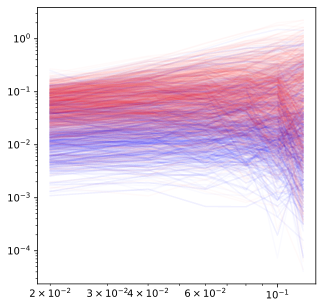

In [78]:
#for ALL lets plot the track msds
rp_ez_ALL_track_msd = RPOC_ez_MSD.combined_store["ALL"].track_MSD
rp_m9_ALL_track_msd = RPOC_m9_MSD.combined_store["ALL"].track_MSD
rp_hex5_ALL_track_msd = RPOC_hex5_MSD.combined_store["ALL"].track_MSD
ll_ez_ALL_track_msd = LL_ez_MSD.combined_store["ALL"].track_MSD
ll_m9_ALL_track_msd = LL_m9_MSD.combined_store["ALL"].track_MSD
ll_hex5_ALL_track_msd = LL_hex5_MSD.combined_store["ALL"].track_MSD

fig =plt.figure(figsize=(5,5))
gspec = gs.GridSpec(1,1)
ax = fig.add_subplot(gspec[0,0])

# counter = 0
# for track_ID,track in ll_ez_ALL_track_msd.items():
#     counter+=1
#     if counter<1000:
#         tau = list(track.keys())
#         msd = list(track.values())
#         ax.plot(tau,msd,color="red",alpha=0.2)
counter = 0
for track_ID,track in rp_ez_ALL_track_msd.items():
    counter+=1
    if counter<1000:
        tau = list(track.keys())
        msd = list(track.values())
        ax.plot(tau,msd,color="blue",alpha=0.02)

counter = 0
for track_ID,track in rp_m9_ALL_track_msd.items():
    counter+=1
    if counter<1000:
        tau = list(track.keys())
        msd = list(track.values())
        ax.plot(tau,msd,color="red",alpha=0.02)


plt.xscale("log")
plt.yscale("log")


plt.show()



In [48]:
rpoc_rif_paths = {"RPOC_RIF":{
    "/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/Rifampacin_Data/20230528/rpoc_ez_rif_100ugml_5min":{"t_string":"OD030","name":"20230528_rpoc_ez_rif_100ugml_5min"},
    "/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/Rifampacin_Data/20230617/rpoc_rif_100ugml":{"t_string":"rpoc_rif","name":"20230617_rpoc_rif_100ugml"},
    "/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/Rifampacin_Data/20230617/rpoc_rif_100ugml_2":{"t_string":"rpoc_rif","name":"20230617_rpoc_rif_100ugml_2"}
}
}

perform_run_analysis_bulk(rpoc_rif_paths,save=True)

All files in the dataset:
/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/Rifampacin_Data/20230528/rpoc_ez_rif_100ugml_5min/Analysis_new/OD030_1_seg.tif_spots.csv
/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/Rifampacin_Data/20230528/rpoc_ez_rif_100ugml_5min/Analysis_new/OD030_2_seg.tif_spots.csv
/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/Rifampacin_Data/20230528/rpoc_ez_rif_100ugml_5min/Analysis_new/OD030_3_seg.tif_spots.csv
/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/Rifampacin_Data/20230528/rpoc_ez_rif_100ugml_5min/Analysis_new/OD030_4_seg.tif_spots.csv
/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/Rifampacin_Data/20230528/rpoc_ez_rif_100ugml_5min/Analysis_new/OD030_5_seg.tif_spots.csv
/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/Rifampacin_Data/20230528/rpoc_ez_rif_100ugml_5min/Analysis_new/OD030_6_seg.tif_spots.csv

max_tag: 150
min_tag: 150
seg_files ['/Users/baljyot/Documents/CODE

/Users/baljyot/opt/anaconda3/envs/SMT_env_BP/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/baljyot/opt/anaconda3/envs/SMT_env_BP/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


SMAUG files saved to: /Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/Rifampacin_Data/20230528/rpoc_ez_rif_100ugml_5min/OD030_MATLAB_dat/SMAUG_AUTO
All files in the dataset:
/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/Rifampacin_Data/20230617/rpoc_rif_100ugml/Analysis_new/rpoc_rif_1_seg.tif_spots.csv
/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/Rifampacin_Data/20230617/rpoc_rif_100ugml/Analysis_new/rpoc_rif_2_seg.tif_spots.csv
/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/Rifampacin_Data/20230617/rpoc_rif_100ugml/Analysis_new/rpoc_rif_3_seg.tif_spots.csv
/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/Rifampacin_Data/20230617/rpoc_rif_100ugml/Analysis_new/rpoc_rif_4_seg.tif_spots.csv
/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/Rifampacin_Data/20230617/rpoc_rif_100ugml/Analysis_new/rpoc_rif_5_seg.tif_spots.csv
/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/Rifampacin_Data/2023

/Users/baljyot/opt/anaconda3/envs/SMT_env_BP/lib/python3.10/site-packages/lmfit/minimizer.py:810: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/Users/baljyot/opt/anaconda3/envs/SMT_env_BP/lib/python3.10/site-packages/lmfit/minimizer.py:817: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))


seg_files ['/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/Rifampacin_Data/20230617/rpoc_rif_100ugml/Segmented_mean/1_rpoc_rif_2_seg.tif', '/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/Rifampacin_Data/20230617/rpoc_rif_100ugml/Segmented_mean/2_rpoc_rif_2_seg.tif', '/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/Rifampacin_Data/20230617/rpoc_rif_100ugml/Segmented_mean/3_rpoc_rif_2_seg.tif', '/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/Rifampacin_Data/20230617/rpoc_rif_100ugml/Segmented_mean/4_rpoc_rif_2_seg.tif', '/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/Rifampacin_Data/20230617/rpoc_rif_100ugml/Segmented_mean/5_rpoc_rif_2_seg.tif']
drop_files []


/Users/baljyot/opt/anaconda3/envs/SMT_env_BP/lib/python3.10/site-packages/lmfit/minimizer.py:810: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/Users/baljyot/opt/anaconda3/envs/SMT_env_BP/lib/python3.10/site-packages/lmfit/minimizer.py:817: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))


seg_files ['/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/Rifampacin_Data/20230617/rpoc_rif_100ugml/Segmented_mean/1_rpoc_rif_3_seg.tif', '/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/Rifampacin_Data/20230617/rpoc_rif_100ugml/Segmented_mean/2_rpoc_rif_3_seg.tif', '/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/Rifampacin_Data/20230617/rpoc_rif_100ugml/Segmented_mean/3_rpoc_rif_3_seg.tif', '/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/Rifampacin_Data/20230617/rpoc_rif_100ugml/Segmented_mean/4_rpoc_rif_3_seg.tif', '/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/Rifampacin_Data/20230617/rpoc_rif_100ugml/Segmented_mean/5_rpoc_rif_3_seg.tif']
drop_files []
seg_files ['/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/Rifampacin_Data/20230617/rpoc_rif_100ugml/Segmented_mean/1_rpoc_rif_4_seg.tif', '/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/Rifampacin_Data/20230617/rpoc_rif_100ugml/S

/Users/baljyot/opt/anaconda3/envs/SMT_env_BP/lib/python3.10/site-packages/lmfit/minimizer.py:810: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/Users/baljyot/opt/anaconda3/envs/SMT_env_BP/lib/python3.10/site-packages/lmfit/minimizer.py:817: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))


seg_files ['/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/Rifampacin_Data/20230617/rpoc_rif_100ugml/Segmented_mean/1_rpoc_rif_5_seg.tif', '/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/Rifampacin_Data/20230617/rpoc_rif_100ugml/Segmented_mean/2_rpoc_rif_5_seg.tif', '/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/Rifampacin_Data/20230617/rpoc_rif_100ugml/Segmented_mean/3_rpoc_rif_5_seg.tif', '/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/Rifampacin_Data/20230617/rpoc_rif_100ugml/Segmented_mean/4_rpoc_rif_5_seg.tif', '/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/Rifampacin_Data/20230617/rpoc_rif_100ugml/Segmented_mean/5_rpoc_rif_5_seg.tif']
drop_files []


/Users/baljyot/opt/anaconda3/envs/SMT_env_BP/lib/python3.10/site-packages/lmfit/minimizer.py:810: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/Users/baljyot/opt/anaconda3/envs/SMT_env_BP/lib/python3.10/site-packages/lmfit/minimizer.py:817: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))


seg_files ['/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/Rifampacin_Data/20230617/rpoc_rif_100ugml/Segmented_mean/1_rpoc_rif_6_seg.tif', '/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/Rifampacin_Data/20230617/rpoc_rif_100ugml/Segmented_mean/2_rpoc_rif_6_seg.tif', '/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/Rifampacin_Data/20230617/rpoc_rif_100ugml/Segmented_mean/3_rpoc_rif_6_seg.tif', '/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/Rifampacin_Data/20230617/rpoc_rif_100ugml/Segmented_mean/4_rpoc_rif_6_seg.tif', '/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/Rifampacin_Data/20230617/rpoc_rif_100ugml/Segmented_mean/5_rpoc_rif_6_seg.tif']
drop_files []


/Users/baljyot/opt/anaconda3/envs/SMT_env_BP/lib/python3.10/site-packages/lmfit/minimizer.py:810: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/Users/baljyot/opt/anaconda3/envs/SMT_env_BP/lib/python3.10/site-packages/lmfit/minimizer.py:817: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))


seg_files ['/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/Rifampacin_Data/20230617/rpoc_rif_100ugml/Segmented_mean/1_rpoc_rif_7_seg.tif', '/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/Rifampacin_Data/20230617/rpoc_rif_100ugml/Segmented_mean/2_rpoc_rif_7_seg.tif', '/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/Rifampacin_Data/20230617/rpoc_rif_100ugml/Segmented_mean/3_rpoc_rif_7_seg.tif', '/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/Rifampacin_Data/20230617/rpoc_rif_100ugml/Segmented_mean/4_rpoc_rif_7_seg.tif', '/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/Rifampacin_Data/20230617/rpoc_rif_100ugml/Segmented_mean/5_rpoc_rif_7_seg.tif']
drop_files []


/Users/baljyot/opt/anaconda3/envs/SMT_env_BP/lib/python3.10/site-packages/lmfit/minimizer.py:810: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/Users/baljyot/opt/anaconda3/envs/SMT_env_BP/lib/python3.10/site-packages/lmfit/minimizer.py:817: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))


seg_files ['/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/Rifampacin_Data/20230617/rpoc_rif_100ugml/Segmented_mean/1_rpoc_rif_8_seg.tif', '/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/Rifampacin_Data/20230617/rpoc_rif_100ugml/Segmented_mean/2_rpoc_rif_8_seg.tif', '/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/Rifampacin_Data/20230617/rpoc_rif_100ugml/Segmented_mean/3_rpoc_rif_8_seg.tif', '/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/Rifampacin_Data/20230617/rpoc_rif_100ugml/Segmented_mean/4_rpoc_rif_8_seg.tif', '/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/Rifampacin_Data/20230617/rpoc_rif_100ugml/Segmented_mean/5_rpoc_rif_8_seg.tif']
drop_files []


/Users/baljyot/opt/anaconda3/envs/SMT_env_BP/lib/python3.10/site-packages/lmfit/minimizer.py:810: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/Users/baljyot/opt/anaconda3/envs/SMT_env_BP/lib/python3.10/site-packages/lmfit/minimizer.py:817: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))


seg_files ['/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/Rifampacin_Data/20230617/rpoc_rif_100ugml/Segmented_mean/1_rpoc_rif_9_seg.tif', '/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/Rifampacin_Data/20230617/rpoc_rif_100ugml/Segmented_mean/2_rpoc_rif_9_seg.tif', '/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/Rifampacin_Data/20230617/rpoc_rif_100ugml/Segmented_mean/3_rpoc_rif_9_seg.tif', '/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/Rifampacin_Data/20230617/rpoc_rif_100ugml/Segmented_mean/4_rpoc_rif_9_seg.tif', '/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/Rifampacin_Data/20230617/rpoc_rif_100ugml/Segmented_mean/5_rpoc_rif_9_seg.tif']
drop_files []


/Users/baljyot/opt/anaconda3/envs/SMT_env_BP/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/baljyot/opt/anaconda3/envs/SMT_env_BP/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


SMAUG files saved to: /Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/Rifampacin_Data/20230617/rpoc_rif_100ugml/rpoc_rif_MATLAB_dat/SMAUG_AUTO
All files in the dataset:
/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/Rifampacin_Data/20230617/rpoc_rif_100ugml_2/Analysis_new/rpoc_rif_1_seg.tif_spots.csv
/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/Rifampacin_Data/20230617/rpoc_rif_100ugml_2/Analysis_new/rpoc_rif_2_seg.tif_spots.csv
/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/Rifampacin_Data/20230617/rpoc_rif_100ugml_2/Analysis_new/rpoc_rif_3_seg.tif_spots.csv
/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/Rifampacin_Data/20230617/rpoc_rif_100ugml_2/Analysis_new/rpoc_rif_4_seg.tif_spots.csv
/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/Rifampacin_Data/20230617/rpoc_rif_100ugml_2/Analysis_new/rpoc_rif_5_seg.tif_spots.csv
/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/Rifampacin_Data

/Users/baljyot/opt/anaconda3/envs/SMT_env_BP/lib/python3.10/site-packages/lmfit/minimizer.py:810: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/Users/baljyot/opt/anaconda3/envs/SMT_env_BP/lib/python3.10/site-packages/lmfit/minimizer.py:817: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))


seg_files ['/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/Rifampacin_Data/20230617/rpoc_rif_100ugml_2/Segmented_mean/1_rpoc_rif_4_seg.tif', '/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/Rifampacin_Data/20230617/rpoc_rif_100ugml_2/Segmented_mean/2_rpoc_rif_4_seg.tif', '/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/Rifampacin_Data/20230617/rpoc_rif_100ugml_2/Segmented_mean/3_rpoc_rif_4_seg.tif', '/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/Rifampacin_Data/20230617/rpoc_rif_100ugml_2/Segmented_mean/4_rpoc_rif_4_seg.tif', '/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/Rifampacin_Data/20230617/rpoc_rif_100ugml_2/Segmented_mean/5_rpoc_rif_4_seg.tif']
drop_files []


/Users/baljyot/opt/anaconda3/envs/SMT_env_BP/lib/python3.10/site-packages/lmfit/minimizer.py:810: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/Users/baljyot/opt/anaconda3/envs/SMT_env_BP/lib/python3.10/site-packages/lmfit/minimizer.py:817: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))


seg_files ['/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/Rifampacin_Data/20230617/rpoc_rif_100ugml_2/Segmented_mean/1_rpoc_rif_5_seg.tif', '/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/Rifampacin_Data/20230617/rpoc_rif_100ugml_2/Segmented_mean/2_rpoc_rif_5_seg.tif', '/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/Rifampacin_Data/20230617/rpoc_rif_100ugml_2/Segmented_mean/3_rpoc_rif_5_seg.tif', '/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/Rifampacin_Data/20230617/rpoc_rif_100ugml_2/Segmented_mean/4_rpoc_rif_5_seg.tif', '/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/Rifampacin_Data/20230617/rpoc_rif_100ugml_2/Segmented_mean/5_rpoc_rif_5_seg.tif']
drop_files []
seg_files ['/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/Rifampacin_Data/20230617/rpoc_rif_100ugml_2/Segmented_mean/1_rpoc_rif_6_seg.tif', '/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/Rifampacin_Data/20230617/rpoc_r

/Users/baljyot/opt/anaconda3/envs/SMT_env_BP/lib/python3.10/site-packages/lmfit/minimizer.py:810: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/Users/baljyot/opt/anaconda3/envs/SMT_env_BP/lib/python3.10/site-packages/lmfit/minimizer.py:817: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))


seg_files ['/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/Rifampacin_Data/20230617/rpoc_rif_100ugml_2/Segmented_mean/1_rpoc_rif_7_seg.tif', '/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/Rifampacin_Data/20230617/rpoc_rif_100ugml_2/Segmented_mean/2_rpoc_rif_7_seg.tif', '/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/Rifampacin_Data/20230617/rpoc_rif_100ugml_2/Segmented_mean/3_rpoc_rif_7_seg.tif', '/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/Rifampacin_Data/20230617/rpoc_rif_100ugml_2/Segmented_mean/4_rpoc_rif_7_seg.tif', '/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/Rifampacin_Data/20230617/rpoc_rif_100ugml_2/Segmented_mean/5_rpoc_rif_7_seg.tif']
drop_files []


/Users/baljyot/opt/anaconda3/envs/SMT_env_BP/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/baljyot/opt/anaconda3/envs/SMT_env_BP/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


SMAUG files saved to: /Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/Rifampacin_Data/20230617/rpoc_rif_100ugml_2/rpoc_rif_MATLAB_dat/SMAUG_AUTO


In [49]:
#load the rif data
rif_folder = "/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/Combined_SMT_THESIS_CHAPTER_5"
rif_pickle = os.path.join(rif_folder,"RPOC_RIF_results.pkl")
with open(rif_pickle,"rb") as f:
    rif_results = pickle.load(f)

    

In [50]:
#perform the MSD calculations
rif_MSD = MSD_Calculations(list(list(rif_results.values())[0].values()),min_track_length=MIN_TRACK_LENGTH,max_track_length=MAX_TRACK_LENGTH)

#save to pickle in the Combined MSD folder
MSD_folder_combined = "/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/Combined_SMT_THESIS_CHAPTER_5/Combined_MSD"
if not os.path.exists(MSD_folder_combined):
    os.makedirs(MSD_folder_combined)
with open(os.path.join(MSD_folder_combined,"RPOC_RIF_MSD_min_{0}_max_{1}.pkl".format(MIN_TRACK_LENGTH,MAX_TRACK_LENGTH)),"wb") as f:
    pickle.dump(rif_MSD,f)



        ##############################################################################################################
        #You have initialized a Calculation class with the following parameters:
        #pixel_size: 0.13
        #frame_length: 0.02
        #pixel_unit: um
        #frame_unit: s
        


In [51]:
#load the rif MSD
rif_MSD = pickle.load(open("/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/Combined_SMT_THESIS_CHAPTER_5/Combined_MSD/RPOC_RIF_MSD_min_{0}_max_{1}.pkl".format(MIN_TRACK_LENGTH,MAX_TRACK_LENGTH),"rb"))


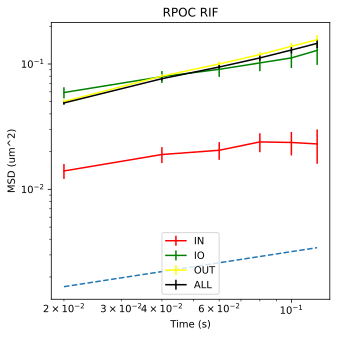

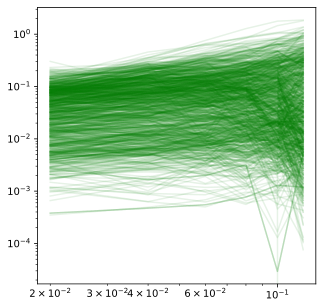

In [69]:
#plot the rif MSD
msd_rif_curve_in = rif_MSD.combined_store["IN"].ensemble_MSD
msd_error_rif_curve_in = rif_MSD.combined_store["IN"].ensemble_MSD_error
msd_rif_curve_io = rif_MSD.combined_store["IO"].ensemble_MSD
msd_error_rif_curve_io = rif_MSD.combined_store["IO"].ensemble_MSD_error
msd_rif_curve_out = rif_MSD.combined_store["OUT"].ensemble_MSD
msd_error_rif_curve_out = rif_MSD.combined_store["OUT"].ensemble_MSD_error
msd_rif_curve_all = rif_MSD.combined_store["ALL"].ensemble_MSD
msd_error_rif_curve_all = rif_MSD.combined_store["ALL"].ensemble_MSD_error

fig =plt.figure(figsize=(5,5))
gspec = gs.GridSpec(1,1)
ax = fig.add_subplot(gspec[0,0])


ax.errorbar(list(msd_rif_curve_in.keys()),list(msd_rif_curve_in.values()),yerr=np.array(list(msd_error_rif_curve_in.values()))*1.96,label="IN",color="red")
ax.errorbar(list(msd_rif_curve_io.keys()),list(msd_rif_curve_io.values()),yerr=np.array(list(msd_error_rif_curve_io.values()))*1.96,label="IO",color="green")
ax.errorbar(list(msd_rif_curve_out.keys()),list(msd_rif_curve_out.values()),yerr=np.array(list(msd_error_rif_curve_out.values()))*1.96,label="OUT",color="yellow")
ax.errorbar(list(msd_rif_curve_all.keys()),list(msd_rif_curve_all.values()),yerr=np.array(list(msd_error_rif_curve_all.values()))*1.96,label="ALL",color="black")
ax.set_xlabel("Time (s)")
ax.set_ylabel("MSD (um^2)")
ax.set_title("RPOC RIF")
ax.set_yscale("log")
ax.set_xscale("log")
ax.legend()
plt.show()


#for ALL lets plot the track msds
rp_rif = rif_MSD.combined_store["ALL"].track_MSD
fig =plt.figure(figsize=(5,5))
gspec = gs.GridSpec(1,1)
ax = fig.add_subplot(gspec[0,0])

# counter = 0
# for track_ID,track in ll_ez_ALL_track_msd.items():
#     counter+=1
#     if counter<1000:
#         tau = list(track.keys())
#         msd = list(track.values())
#         ax.plot(tau,msd,color="red",alpha=0.2)
counter = 0
for track_ID,track in rp_rif.items():
    counter+=1
    if counter<1000:
        tau = list(track.keys())
        msd = list(track.values())
        ax.plot(tau,msd,color="green",alpha=0.1)



plt.xscale("log")
plt.yscale("log")


plt.show()


